#### Dependencies

In [ ]:
%pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

#### Download the dataset

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 145MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:


char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)



The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num(['o','g','u','z']).numpy()


array([15,  7, 21, 26])

In [ ]:
num_to_char([15,  7,  21, 26]).numpy()

array([b'o', b'g', b'u', b'z'], dtype=object)

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39 12 39 19  9 24 39 14 15 23], shape=(21,), dtype=int64)
tf.Tensor(b'bin blue at l six now', shape=(), dtype=string)


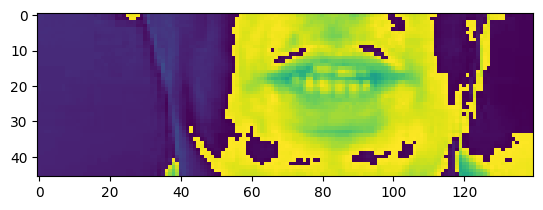

In [ ]:
print(alignments)
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))
plt.imshow(frames[40])

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

#### Data pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)



In [ ]:
print(len(test))
frames, alignments = data.as_numpy_iterator().next()
len(frames)

50


2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[1.3562226 ],
          [1.3562226 ],
          [1.4337211 ],
          ...,
          [0.23249531],
          [0.27124453],
          [0.27124453]],

         [[1.3562226 ],
          [1.3562226 ],
          [1.4337211 ],
          ...,
          [0.19374609],
          [0.23249531],
          [0.27124453]],

         [[1.2787242 ],
          [1.2787242 ],
          [1.2787242 ],
          ...,
          [0.27124453],
          [0.19374609],
          [0.19374609]],

         ...,

         [[0.96873045],
          [0.96873045],
          [0.96873045],
          ...,
          [9.6873045 ],
          [9.648555  ],
          [9.609806  ]],

         [[0.96873045],
          [0.96873045],
          [0.96873045],
          ...,
          [9.532308  ],
          [9.493558  ],
          [9.454809  ]],

         [[0.96873045],
          [0.96873045],
          [0.96873045],
          ...,
          [9.609806  ],
          [9.493558  ],
          [9.454809  ]]],


        [[[1.3562

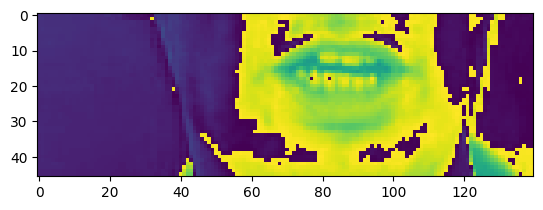

In [ ]:
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at v five again'>

#### Desing the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeeeeeepppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

#### Training Loop

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)



In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [ ]:
model.save("my_model.keras")

#### Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 146MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
# %pip install opencv-python==4.6.0.66 tensorflow==2.10.1 imageio==2.23.0 matplotlib==3.6.2 gdown==4.6.0

In [ ]:
model.load_weights('./models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()
sample = test_data.next()

In [ ]:
SAMPLe_2 = test_data.next()

In [ ]:
yhat = model.predict(SAMPLe_2[0])

1/1 [==============================] - 1s 759ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in SAMPLe_2[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by v nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red with n two please'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by v nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red with two please'>]

In [ ]:
import jiwer
from tqdm import tqdm
def wer(reference, hypothesis):
    return jiwer.wer(reference, hypothesis)

def cer(reference, hypothesis):
    return jiwer.cer(reference, hypothesis)

In [ ]:
test_data = test.as_numpy_iterator()

wer_scores = []
cer_scores = []

for batch in tqdm(test_data, desc="Processing Test Data"):
    input_data, target_data = batch

    predictions = model.predict(input_data)

    decoded_predictions = tf.keras.backend.ctc_decode(
        predictions, input_length=[75, 75], greedy=True
    )[0][0].numpy()

    for reference, hypothesis in zip(target_data, decoded_predictions):
        reference_str = tf.strings.reduce_join([num_to_char(word) for word in reference]).numpy().decode('utf-8')
        hypothesis_str = tf.strings.reduce_join([num_to_char(word) for word in hypothesis]).numpy().decode('utf-8')
        print("reference_str", reference_str)
        print("hypothesis_str", hypothesis_str)
        wer_score = wer(reference_str, hypothesis_str)
        cer_score = cer(reference_str, hypothesis_str)

        wer_scores.append(wer_score)
        cer_scores.append(cer_score)

    if len(wer_scores) % 5 == 0:
        avg_wer = sum(wer_scores) / len(wer_scores)
        avg_cer = sum(cer_scores) / len(cer_scores)
        print(f"Processed {len(wer_scores)} samples - Avg. WER: {avg_wer:.4f}, Avg. CER: {avg_cer:.4f}")

avg_wer = sum(wer_scores) / len(wer_scores)
avg_cer = sum(cer_scores) / len(cer_scores)

print(f"Final Results - Avg. WER: {avg_wer:.4f}, Avg. CER: {avg_cer:.4f}")

Processing Test Data: 0it [00:00, ?it/s]

1/1 [==============================] - 1s 859ms/step
reference_str lay white with m one soon
hypothesis_str lay white with m one soon
reference_str set red with v two please
hypothesis_str 

Processing Test Data: 1it [04:07, 247.58s/it]

set red with v two please
1/1 [==============================] - 1s 854ms/step
reference_str lay blue in j six now
hypothesis_str lay blue in j six now


Processing Test Data: 2it [04:08, 102.61s/it]

reference_str set blue in g five soon
hypothesis_str set blue in g five soon
1/1 [==============================] - 1s 845ms/step


Processing Test Data: 3it [04:09, 56.22s/it] 

reference_str bin green with o three soon
hypothesis_str bin green with o three soon
reference_str place white by k two please
hypothesis_str place white by k two please
1/1 [==============================] - 1s 870ms/step


Processing Test Data: 4it [04:10, 34.43s/it]

reference_str lay white by s two please
hypothesis_str lay white by s two please
reference_str place blue at c one soon
hypothesis_str place blue at c one soon
1/1 [==============================] - 1s 856ms/step


Processing Test Data: 5it [04:11, 22.38s/it]

reference_str lay green with t one soon
hypothesis_str lay green with t one soon
reference_str place green with e eight please
hypothesis_str place green with e eight please
Processed 10 samples - Avg. WER: 0.0000, Avg. CER: 0.0000
1/1 [==============================] - 1s 797ms/step


Processing Test Data: 6it [04:12, 15.11s/it]

reference_str set white in u six please
hypothesis_str set white in u six please
reference_str bin green by b zero now
hypothesis_str bin green by b zero now
1/1 [==============================] - 1s 859ms/step


Processing Test Data: 7it [04:13, 10.50s/it]

reference_str bin green with u six now
hypothesis_str bin green with u six now
reference_str place red at j three again
hypothesis_str place red at j three again
1/1 [==============================] - 1s 809ms/step


Processing Test Data: 8it [04:14,  7.47s/it]

reference_str lay white with m three again
hypothesis_str lay white with m three again
reference_str lay blue in x four now
hypothesis_str lay blue in x four now
1/1 [==============================] - 1s 805ms/step


Processing Test Data: 9it [04:15,  5.45s/it]

reference_str set white at o seven again
hypothesis_str set white at o seven again
reference_str set green by j two please
hypothesis_str set green by j two please
1/1 [==============================] - 1s 820ms/step


Processing Test Data: 10it [04:16,  4.07s/it]

reference_str bin white by a four now
hypothesis_str bin white by a four now
reference_str place green at k two now
hypothesis_str place green at k two now
Processed 20 samples - Avg. WER: 0.0000, Avg. CER: 0.0000
1/1 [==============================] - 1s 834ms/step


Processing Test Data: 11it [04:17,  3.13s/it]

reference_str place blue with x one soon
hypothesis_str place blue with x one soon
reference_str bin blue by m two please
hypothesis_str bin blue by m two please
1/1 [==============================] - 1s 846ms/step


Processing Test Data: 12it [04:18,  2.48s/it]

reference_str place red by d two please
hypothesis_str place red by d two please
reference_str set green in o eight please
hypothesis_str set green in o eight please
1/1 [==============================] - 1s 853ms/step


Processing Test Data: 13it [04:19,  2.04s/it]

reference_str set blue at h zero please
hypothesis_str set blue at h zero please
reference_str bin blue with m six please
hypothesis_str bin blue with m six please
1/1 [==============================] - 1s 859ms/step


Processing Test Data: 14it [04:20,  1.73s/it]

reference_str lay red at r two please
hypothesis_str lay red at r two please
reference_str bin white with u one soon
hypothesis_str bin white with u one soon
1/1 [==============================] - 1s 870ms/step


Processing Test Data: 15it [04:21,  1.52s/it]

reference_str set green with j five soon
hypothesis_str set green with j five soon
reference_str place white with e two please
hypothesis_str place white with e two please
Processed 30 samples - Avg. WER: 0.0000, Avg. CER: 0.0000
1/1 [==============================] - 1s 843ms/step


Processing Test Data: 16it [04:22,  1.37s/it]

reference_str set white in b three soon
hypothesis_str set white in b three soon
reference_str set red at h six please
hypothesis_str set red at h six please
1/1 [==============================] - 1s 793ms/step


Processing Test Data: 17it [04:23,  1.25s/it]

reference_str bin white with u three again
hypothesis_str bin white with u three again
reference_str lay green at m zero please
hypothesis_str lay green at m zero please
1/1 [==============================] - 1s 836ms/step


Processing Test Data: 18it [04:24,  1.18s/it]

reference_str lay blue by k four now
hypothesis_str lay blue by k four now
reference_str place green with l three again
hypothesis_str place green with l three again
1/1 [==============================] - 1s 837ms/step


Processing Test Data: 19it [04:25,  1.12s/it]

reference_str lay blue in d four please
hypothesis_str lay blue in d four please
reference_str lay white sp by f three soon
hypothesis_str lay white sp by f three soon
1/1 [==============================] - 1s 851ms/step


Processing Test Data: 20it [04:26,  1.10s/it]

reference_str lay red by l zero now
hypothesis_str lay red by l zero now
reference_str lay green in f three again
hypothesis_str lay green in three again
Processed 40 samples - Avg. WER: 0.0042, Avg. CER: 0.0019
1/1 [==============================] - 1s 849ms/step


Processing Test Data: 21it [04:27,  1.07s/it]

reference_str set red in t eight now
hypothesis_str set red in t eight now
reference_str bin red with n zero now
hypothesis_str bin red with n zero now
1/1 [==============================] - 1s 833ms/step


Processing Test Data: 22it [04:28,  1.05s/it]

reference_str set blue at a six please
hypothesis_str set blue at a six please
reference_str bin blue with t zero please
hypothesis_str bin blue with t zero please
1/1 [==============================] - 1s 828ms/step


Processing Test Data: 23it [04:29,  1.03s/it]

reference_str lay red in k five again
hypothesis_str lay red in k five again
reference_str bin green at n seven again
hypothesis_str bin green at n seven again
1/1 [==============================] - 1s 835ms/step


Processing Test Data: 24it [04:30,  1.02s/it]

reference_str lay green at m one again
hypothesis_str lay green at m one again
reference_str set white by v five again
hypothesis_str set white by v five again
1/1 [==============================] - 1s 841ms/step


Processing Test Data: 25it [04:31,  1.01s/it]

reference_str bin white by a seven again
hypothesis_str bin white by a seven again
reference_str set blue at n five again
hypothesis_str set blue at n five again
Processed 50 samples - Avg. WER: 0.0033, Avg. CER: 0.0015
1/1 [==============================] - 1s 858ms/step


Processing Test Data: 26it [04:32,  1.01s/it]

reference_str place red at p four now
hypothesis_str place red at p four now
reference_str lay white at e nine soon
hypothesis_str lay white at e nine soon
1/1 [==============================] - 1s 890ms/step


Processing Test Data: 27it [04:33,  1.03s/it]

reference_str bin white in m seven again
hypothesis_str bin white in m seven again
reference_str bin red sp by g two now
hypothesis_str bin red bp by two now
1/1 [==============================] - 1s 896ms/step


Processing Test Data: 28it [04:34,  1.04s/it]

reference_str place red by x five again
hypothesis_str place red by x five again
reference_str set blue with o zero now
hypothesis_str set blue with o zero now
1/1 [==============================] - 1s 874ms/step


Processing Test Data: 29it [04:36,  1.04s/it]

reference_str bin green at n five soon
hypothesis_str bin green at n five soon
reference_str place white in j three soon
hypothesis_str place white in j three soon
1/1 [==============================] - 1s 849ms/step


Processing Test Data: 30it [04:37,  1.03s/it]

reference_str set blue by b zero please
hypothesis_str set blue by b zero please
reference_str bin blue with g zero now
hypothesis_str bin blue with g zero now
Processed 60 samples - Avg. WER: 0.0075, Avg. CER: 0.0035
1/1 [==============================] - 1s 851ms/step


Processing Test Data: 31it [04:38,  1.03s/it]

reference_str bin red in z seven soon
hypothesis_str bin red in z seven soon
reference_str set red in h zero now
hypothesis_str set red in h zero now
1/1 [==============================] - 1s 837ms/step


Processing Test Data: 32it [04:39,  1.02s/it]

reference_str place green at y zero now
hypothesis_str place green at y zero now
reference_str set green with d zero now
hypothesis_str set green with d zero now
1/1 [==============================] - 1s 850ms/step


Processing Test Data: 33it [04:40,  1.02s/it]

reference_str bin green at t nine soon
hypothesis_str bin green at t nine soon
reference_str place white by x eight now
hypothesis_str place white by x eight now
1/1 [==============================] - 1s 845ms/step


Processing Test Data: 34it [04:41,  1.01s/it]

reference_str set white with p two now
hypothesis_str set white with p two now
reference_str lay green by m two now
hypothesis_str lay green by m two now
1/1 [==============================] - 1s 854ms/step


Processing Test Data: 35it [04:42,  1.02s/it]

reference_str lay blue in q one soon
hypothesis_str lay blue in q one soon
reference_str bin green at a six now
hypothesis_str bin green at a six now
Processed 70 samples - Avg. WER: 0.0065, Avg. CER: 0.0030
1/1 [==============================] - 1s 840ms/step


Processing Test Data: 36it [04:43,  1.01s/it]

reference_str place white with y four please
hypothesis_str place white with y four please
reference_str bin green by h four now
hypothesis_str bin green by h four now
1/1 [==============================] - 1s 846ms/step


Processing Test Data: 37it [04:44,  1.01s/it]

reference_str lay green in z four please
hypothesis_str lay green in z four please
reference_str place red with x nine again
hypothesis_str place red with x nine again
1/1 [==============================] - 1s 880ms/step


Processing Test Data: 38it [04:45,  1.02s/it]

reference_str place green at y two please
hypothesis_str place green at y two please
reference_str bin red at s six now
hypothesis_str bin red at s six now
1/1 [==============================] - 1s 843ms/step


Processing Test Data: 39it [04:46,  1.02s/it]

reference_str bin green by h five soon
hypothesis_str bin green by h five soon
reference_str place blue with x three again
hypothesis_str place blue with x three again
1/1 [==============================] - 1s 780ms/step


Processing Test Data: 40it [04:47,  1.02s/it]

reference_str set white with j zero please
hypothesis_str set white with j zero please
reference_str place blue in b seven soon
hypothesis_str place blue in b seven soon
Processed 80 samples - Avg. WER: 0.0057, Avg. CER: 0.0026
1/1 [==============================] - 1s 808ms/step


Processing Test Data: 41it [04:48,  1.01s/it]

reference_str lay red with f two please
hypothesis_str lay red with k two please
reference_str bin white in g two please
hypothesis_str bin white in g two please
1/1 [==============================] - 1s 853ms/step


Processing Test Data: 42it [04:49,  1.01s/it]

reference_str set white in o zero now
hypothesis_str set white in o zero now
reference_str set white at u nine soon
hypothesis_str set white at u nine soon
1/1 [==============================] - 1s 754ms/step


Processing Test Data: 43it [04:50,  1.00it/s]

reference_str bin red in s two now
hypothesis_str bin red in s two now
reference_str bin blue at z four now
hypothesis_str bin blue at z four now
1/1 [==============================] - 1s 830ms/step


Processing Test Data: 44it [04:51,  1.01it/s]

reference_str bin blue with t one again
hypothesis_str bin blue with t one again
reference_str lay blue by q eight now
hypothesis_str lay blue by q eight now
1/1 [==============================] - 1s 730ms/step


Processing Test Data: 45it [04:52,  1.02it/s]

reference_str place green in x six now
hypothesis_str place green in x six now
reference_str set blue in a two please
hypothesis_str set blue in a two please
Processed 90 samples - Avg. WER: 0.0069, Avg. CER: 0.0027
1/1 [==============================] - 1s 858ms/step


Processing Test Data: 46it [04:53,  1.01it/s]

reference_str set white with p five again
hypothesis_str set white with five again
reference_str place white in j five again
hypothesis_str place white in j five again
1/1 [==============================] - 1s 844ms/step


Processing Test Data: 47it [04:54,  1.00s/it]

reference_str set green in b eight now
hypothesis_str lay gree it u eg now
reference_str bin red in s five again
hypothesis_str bin red in s five again
1/1 [==============================] - 1s 847ms/step


Processing Test Data: 48it [04:55,  1.00s/it]

reference_str lay white in y seven soon
hypothesis_str lay white in y seven soon
reference_str lay green at f five soon
hypothesis_str lay green at f five soon
1/1 [==============================] - 1s 705ms/step


Processing Test Data: 49it [04:56,  1.04it/s]

reference_str bin white with n eight please
hypothesis_str bin white with n eight please
reference_str place white in d zero please
hypothesis_str place white in d zero please
1/1 [==============================] - 1s 769ms/step


Processing Test Data: 50it [04:56,  5.94s/it]

reference_str place green by y five soon
hypothesis_str place green by y five soon
reference_str bin green in a two now
hypothesis_str bin green in a two now
Processed 100 samples - Avg. WER: 0.0162, Avg. CER: 0.0070
Final Results - Avg. WER: 0.0162, Avg. CER: 0.0070
